# Solar

In [1]:
#|code-fold: true
#|output: false
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import matplotlib.ticker as ticker

from pathlib import Path
from tqdm import tqdm
import datetime
import torch
import torch.optim as optim
from torchvision.transforms importRandomApply, ColorJitter
from torchmetrics.functional import jaccard_index

from processing import prep_data, get_unlabeled_tensors, get_labeled_tensors, get_weights
from constants import RUNS_FOLDER
from step_by_step import StepByStep, load_tensor, get_means_and_stdevs 
from models import Segnet
from evaluate import display_images, evaluate_unlabeled

plt.style.use('fivethirtyeight')

def get_current_datetime():
    return datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')

%load_ext autoreload
%autoreload 2

# Data processing

In [57]:
proj_dir = Path('.').resolve().parent
data_dir = proj_dir / 'data'
batch_size = 32
n_channels = 3
shape = (3, 256, 256)
title_mapping = {'R1C1': 0, 'commonrack': 1, 'commonpanel': 2, 'densepanel': 3}
n_classes = len(title_mapping)

jitter = ColorJitter(brightness=(0.2, 1.0), contrast=(0.3, 1.0))  # jitter will change every time it is called
applier = RandomApply(torch.nn.ModuleList([jitter]), p=0.3)

In [58]:
labeled_tensor_x, labeled_tensor_y, labeled_idx_map = get_labeled_tensors(data_dir, title_mapping)
train_loader, val_loader, val_idx_map, normalizer, val_composer, weights = prep_data(labeled_tensor_x, 
                                                                                     labeled_tensor_y, 
                                                                                     labeled_idx_map, 
                                                                                     applier, 
                                                                                     n_classes,
                                                                                     batch_size=batch_size)
unlabeled_tensor_x, unlabeled_tensor_y, unlabeled_idx_map =  get_unlabeled_tensors(data_dir, shape)

100%|██████████| 6477/6477 [00:20<00:00, 323.70it/s]


# Training

In [23]:
n_classes

4

In [24]:
segnet = Segnet(n_channels=n_channels, n_classes=n_classes)
optimizer = optim.Adam(segnet.parameters(), lr=3e-4)

torch.manual_seed(17)
sbs = StepByStep(segnet, optimizer, torch.nn.CrossEntropyLoss(weight=weights))
sbs.set_loaders(train_loader, val_loader)

In [25]:
run_name = 'four_class_segnet_all_pixels_gpu'    
run_folder = Path(RUNS_FOLDER) / (get_current_datetime() + '_' + run_name)
Path(run_folder).mkdir(exist_ok=True, parents=True)

In [45]:
sbs.train(20)

Failed to set loader seed.


100%|██████████| 20/20 [00:46<00:00,  2.34s/it]


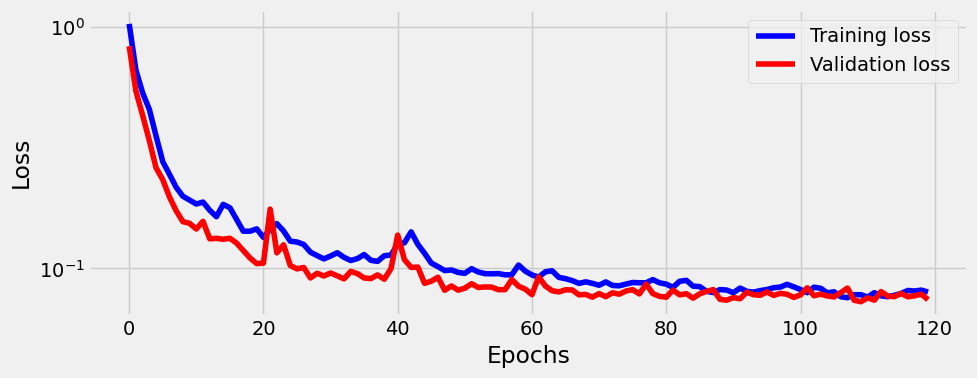

In [59]:
_ = sbs.plot_losses()

# Evaluation

In [47]:
print(sbs.get_metric(jaccard_index))
sbs.save_checkpoint(run_folder / (get_current_datetime() + '_' + 'checkpoint_jaccard_index_' + f'{sbs.metric:.3f}' + '.tar'))

100%|██████████| 3/3 [00:00<00:00,  3.15it/s]

0.7168409


In [48]:
val_loader_iter = iter(val_loader)
batch_idx = -1

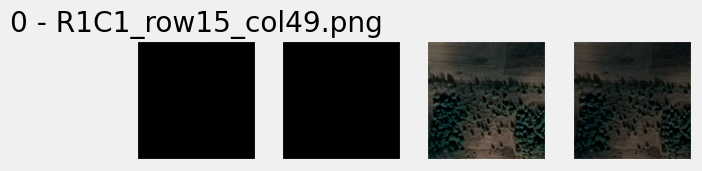

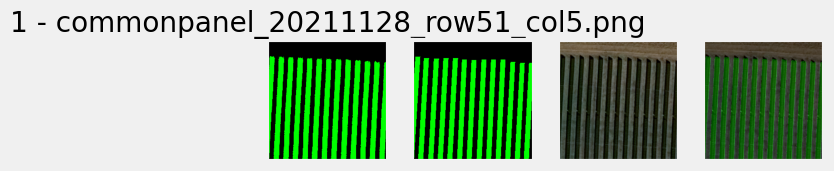

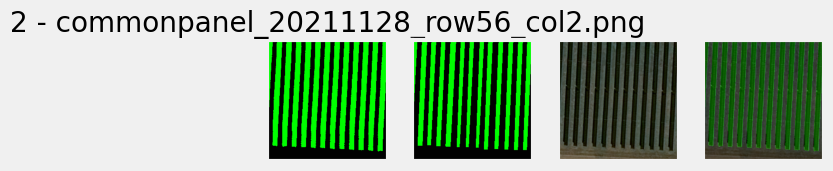

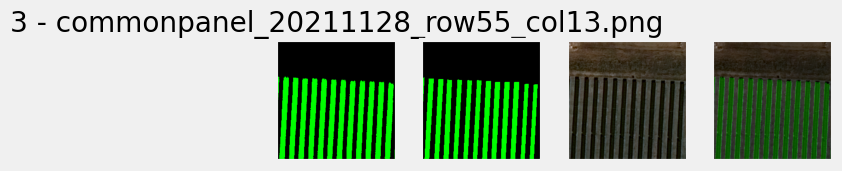

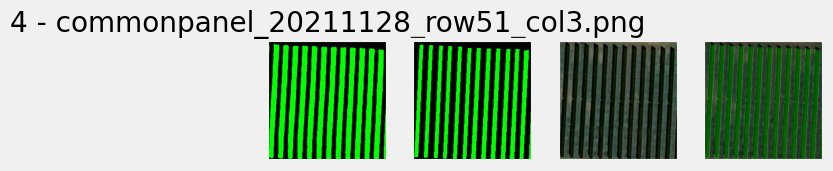

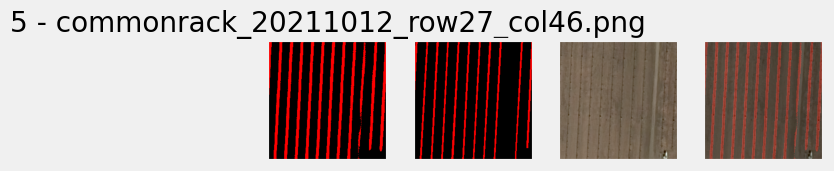

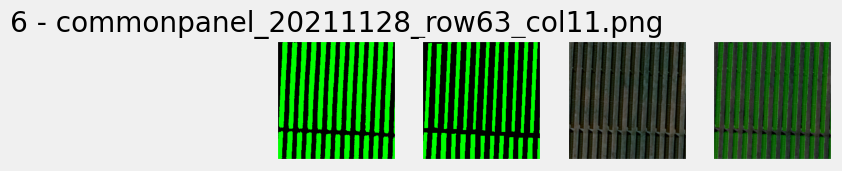

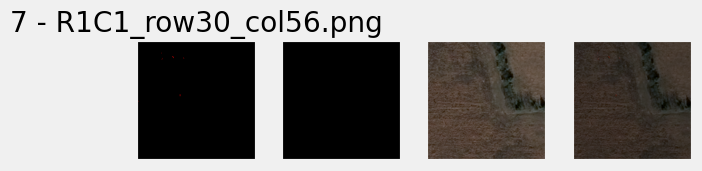

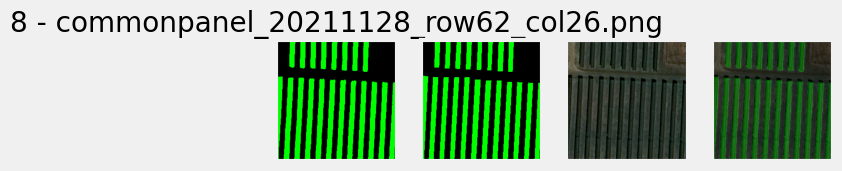

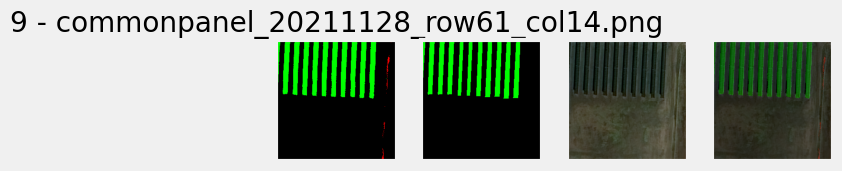

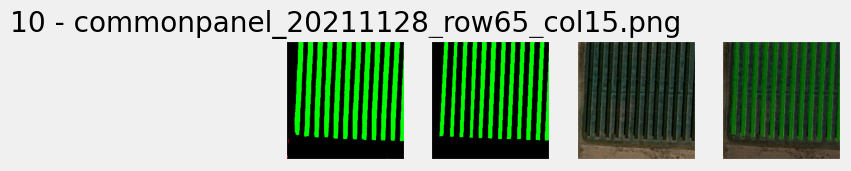

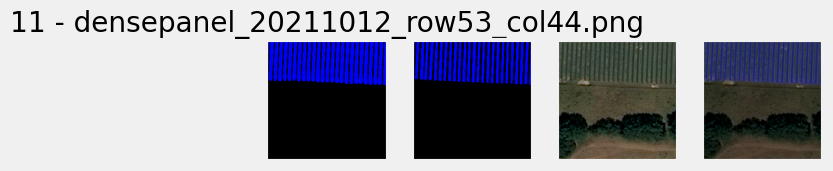

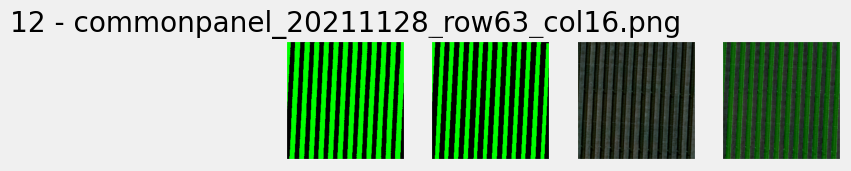

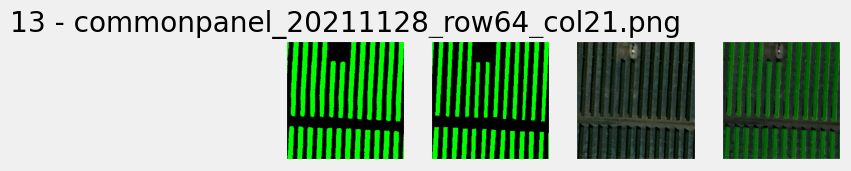

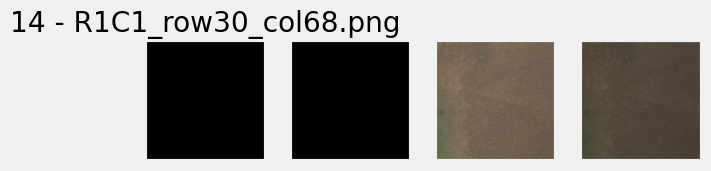

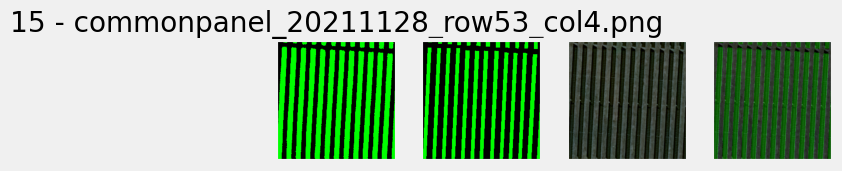

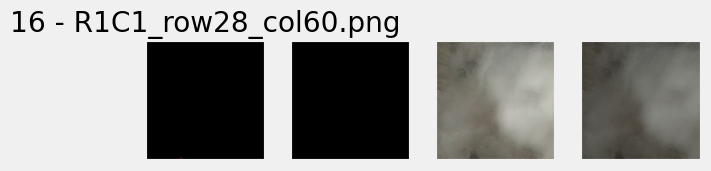

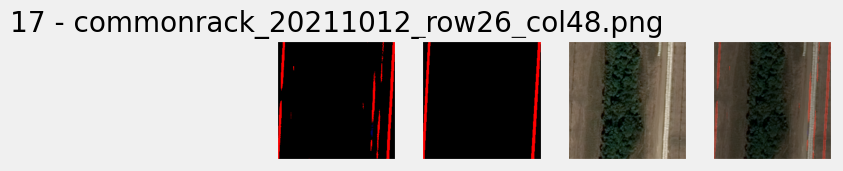

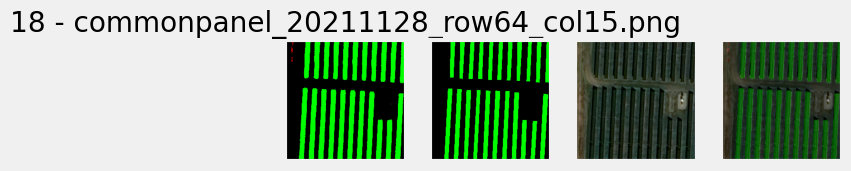

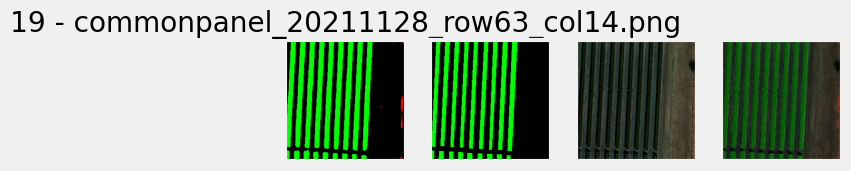

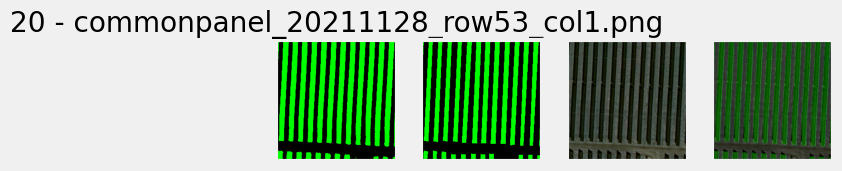

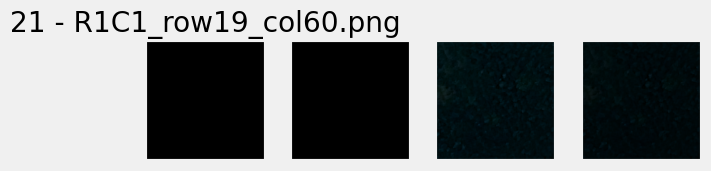

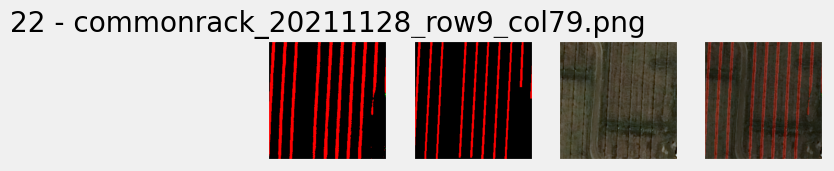

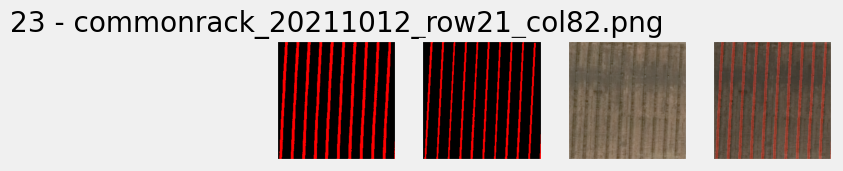

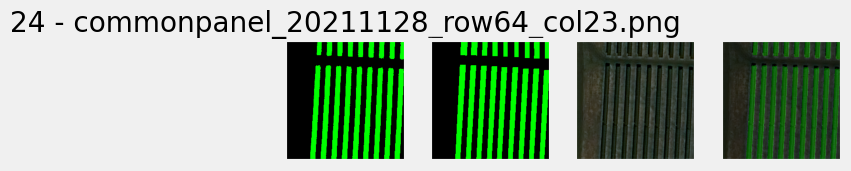

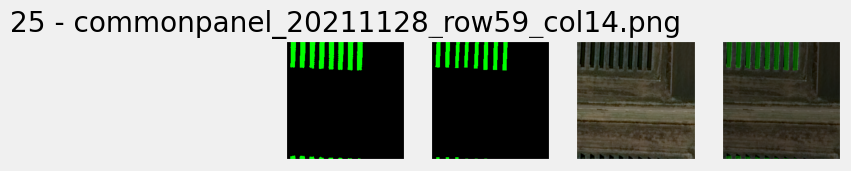

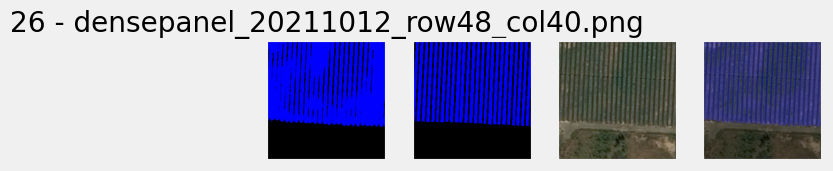

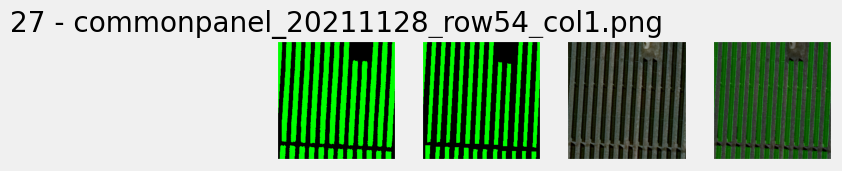

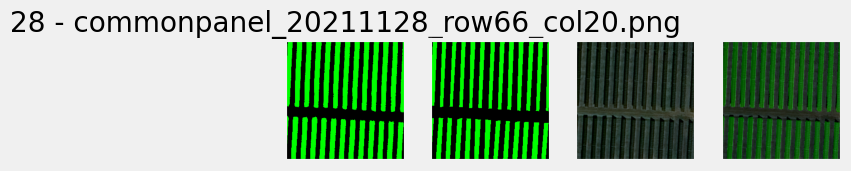

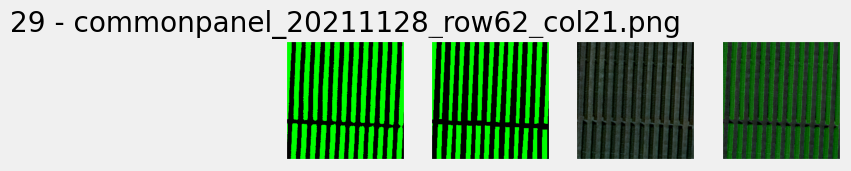

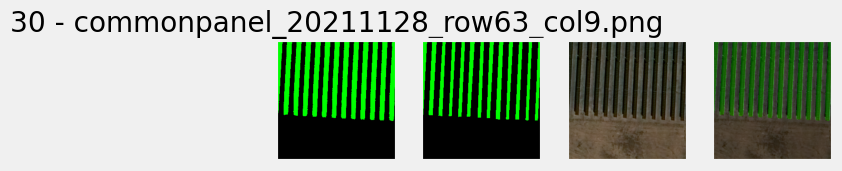

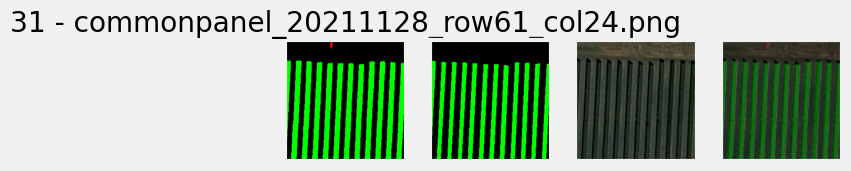

In [49]:
x_val, y_val = next(val_loader_iter)
batch_idx += 1
y_pred = sbs.predict(x_val, to_numpy=False).argmax(1)
display_images(x_val, y_val, y_pred, n_classes, normalizer, 
               idx_map=val_idx_map, idx_offset=batch_idx*batch_size)

In [60]:
evaluate_unlabeled(unlabeled_tensor_x, unlabeled_tensor_y, val_composer, n_classes, normalizer, sbs, run_folder, unlabeled_idx_map)

100%|██████████| 203/203 [07:32<00:00,  2.23s/it]


Expect 1-2 minutes ...
File was not found, using defaults.


2998it [00:02, 1132.85it/s]


Done stitching to: /home/runs/2023_01_24_08_16_four_class_segnet_all_pixels_gpu/R1C2_predicted.png
Expect 1-2 minutes ...
File was not found, using defaults.


2998it [00:07, 376.54it/s]


Done stitching to: /home/runs/2023_01_24_08_16_four_class_segnet_all_pixels_gpu/R1C2_overlayed.png
Expect 1-2 minutes ...
File was not found, using defaults.


1305it [00:01, 1224.72it/s]


Done stitching to: /home/runs/2023_01_24_08_16_four_class_segnet_all_pixels_gpu/R2C1_predicted.png
Expect 1-2 minutes ...
File was not found, using defaults.


1305it [00:03, 361.27it/s]


Done stitching to: /home/runs/2023_01_24_08_16_four_class_segnet_all_pixels_gpu/R2C1_overlayed.png
Expect 1-2 minutes ...
File was not found, using defaults.


136it [00:00, 1210.15it/s]


Done stitching to: /home/runs/2023_01_24_08_16_four_class_segnet_all_pixels_gpu/R2C2_predicted.png
Expect 1-2 minutes ...
File was not found, using defaults.


136it [00:00, 371.53it/s]


Done stitching to: /home/runs/2023_01_24_08_16_four_class_segnet_all_pixels_gpu/R2C2_overlayed.png
